We tried running several other models. Didn't work out since the best algorithm to deal with a huge number of features is the random forest

Tried to find correlation between the data by using covariance matrix. Didn't worked out.

Tried to treat the data as time series to see what we could derive from it

Tried PCA + RF

Tried to spot outliers

## Structure of the Dataset

### Main data

In [2]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns; sns.set()

In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import mean_squared_error

In [4]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error


In [5]:
problem = imp.load_source('', 'problem.py') #problem is a module with different methods
X_df, y_array = problem.get_train_data() #get_train_data() is one of those methods

X_train = X_df.copy()
y_train = y_array.copy()

In [7]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [145]:
X_train.describe()

,WeeksToDeparture,std_wtd
count,8902.000000,8902.000000
mean,11.446469,8.617773
std,2.787140,2.139604
min,2.625000,2.160247
25%,9.523810,7.089538
50%,11.300000,8.571116
75%,13.240000,10.140521
max,23.163265,15.862216


In [146]:
X_train.shape

(8902, 5)

In [147]:
pd.DataFrame(data=X_train.isna().sum(), columns=["Number of NAs"]).transpose()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
Number of NAs,0,0,0,0,0


There are no missing values

### Additional Data (IATA)

In [148]:
#Join iata data
iata = pd.read_csv('data/IATA_US_CODES.csv')
iata['IATA Code']=iata['IATA Code'].astype(str)
iata['IATA Code']=iata['IATA Code'].str.rstrip()
iata=iata.set_index('IATA Code')
iata_dep=iata.add_suffix('_Dep')
iata_arr=iata.add_suffix('_Arr')

In [149]:
X_train=X_train.join(iata_dep, on='Departure', how='left')
X_train=X_train.join(iata_arr, on='Arrival', how='left')
X_train['Departure']

0       ORD
1       LAS
2       DEN
3       ATL
4       DEN
       ... 
8897    DTW
8898    DFW
8899    SFO
8900    ORD
8901    DTW
Name: Departure, Length: 8902, dtype: object

In [150]:
X_train

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Rank_2018_Dep,Airports (large hubs)_Dep,Major city served_Dep,State_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,Rank_2018_Arr,Airports (large hubs)_Arr,Major city served_Arr,State_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr
0,2012-06-19,ORD,DFW,12.875000,9.812647,3,O'Hare International Airport,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668",4,Dallas/Fort Worth International Airport,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832"
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,McCarran International Airport,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver International Airport,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043"
2,2012-10-05,DEN,LAX,10.863636,9.035883,5,Denver International Airport,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",2,Los Angeles International Airport,Los Angeles,CA,"42,626,783","41,232,432","39,636,042","36,351,226"
3,2011-10-09,ATL,ORD,11.480000,7.990202,1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732",3,O'Hare International Airport,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668"
4,2012-02-21,DEN,SFO,11.450000,9.517159,5,Denver International Airport,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",7,San Francisco International Airport,San Francisco,CA,"27,794,154","26,900,048","25,707,101","24,190,549"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967,19,Detroit Metropolitan Airport,Detroit,MI,"17,437,716","17,036,092","16,826,287","16,255,520",1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732"
8898,2012-09-25,DFW,ORD,12.772727,10.641034,4,Dallas/Fort Worth International Airport,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832",3,O'Hare International Airport,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668"
8899,2012-01-19,SFO,LAS,11.047619,7.908705,7,San Francisco International Airport,San Francisco,CA,"27,794,154","26,900,048","25,707,101","24,190,549",9,McCarran International Airport,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231"
8900,2013-02-03,ORD,PHL,6.076923,4.030334,3,O'Hare International Airport,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668",20,Philadelphia International Airport,Philadelphia,PA,"15,285,948","14,271,243","14,564,419","15,101,318"


In [151]:
X_train=X_train.drop(['Airports (large hubs)_Dep', 'Airports (large hubs)_Arr'], axis=1)
X_train

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Rank_2018_Dep,Major city served_Dep,State_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,Rank_2018_Arr,Major city served_Arr,State_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr
0,2012-06-19,ORD,DFW,12.875000,9.812647,3,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668",4,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832"
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043"
2,2012-10-05,DEN,LAX,10.863636,9.035883,5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",2,Los Angeles,CA,"42,626,783","41,232,432","39,636,042","36,351,226"
3,2011-10-09,ATL,ORD,11.480000,7.990202,1,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732",3,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668"
4,2012-02-21,DEN,SFO,11.450000,9.517159,5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",7,San Francisco,CA,"27,794,154","26,900,048","25,707,101","24,190,549"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967,19,Detroit,MI,"17,437,716","17,036,092","16,826,287","16,255,520",1,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732"
8898,2012-09-25,DFW,ORD,12.772727,10.641034,4,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832",3,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668"
8899,2012-01-19,SFO,LAS,11.047619,7.908705,7,San Francisco,CA,"27,794,154","26,900,048","25,707,101","24,190,549",9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231"
8900,2013-02-03,ORD,PHL,6.076923,4.030334,3,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668",20,Philadelphia,PA,"15,285,948","14,271,243","14,564,419","15,101,318"


In [152]:
X_train['2018_Arr'].astype

<bound method NDFrame.astype of 0       32,800,721 
1       31,363,573 
2       42,626,783 
3       39,874,879 
4       27,794,154 
           ...     
8897    51,866,464 
8898    39,874,879 
8899    23,655,285 
8900    15,285,948 
8901    51,866,464 
Name: 2018_Arr, Length: 8902, dtype: object>

In [153]:
iata['2018']=iata['2018'].str.replace(',','')
iata['2017']=iata['2017'].str.replace(',','')
iata['2016']=iata['2016'].str.replace(',','')
iata['2015']=iata['2015'].str.replace(',','')
iata['2018']=iata['2018'].str.replace('\xa0','')
iata['2017']=iata['2017'].str.replace('\xa0','')
iata['2016']=iata['2016'].str.replace('\xa0','')
iata['2015']=iata['2015'].str.replace('\xa0','')


In [154]:
iata['2018'] = iata['2018'].astype(int)

In [155]:
iata

,Rank_2018,Airports (large hubs),Major city served,State,2018,2017,2016,2015
IATA Code,,,,,,,,
ATL,1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,51866464,50251964,50501858,49340732
LAX,2,Los Angeles International Airport,Los Angeles,CA,42626783,41232432,39636042,36351226
ORD,3,O'Hare International Airport,Chicago,IL,39874879,38593028,37589899,36305668
DFW,4,Dallas/Fort Worth International Airport,Dallas/Fort Worth,TX,32800721,31816933,31283579,31589832
DEN,5,Denver International Airport,Denver,CO,31363573,29809097,28267394,26280043
JFK,6,John F. Kennedy International Airport,New York,NY,30541459,29533154,29239151,27782369
SFO,7,San Francisco International Airport,San Francisco,CA,27794154,26900048,25707101,24190549
SEA,8,Seattle–Tacoma International Airport,Seattle/Tacoma,WA,24894338,22639124,21887110,21231781
LAS,9,McCarran International Airport,Las Vegas,NV,23655285,23364393,22833267,21824231


In [156]:
#Add distance between cities
us_cities = pd.read_csv('data/uscities.csv')
us_cities

,city,city_ascii,state_id,state_name,county_fips,county_name,county_fips_all,county_name_all,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,South Creek,South Creek,WA,Washington,53053,Pierce,53053,Pierce,46.9994,-122.3921,2500.0,125.0,polygon,False,True,America/Los_Angeles,3,98580 98387 98338,1840116412
1,Roslyn,Roslyn,WA,Washington,53037,Kittitas,53037,Kittitas,47.2507,-121.0989,947.0,84.0,polygon,False,True,America/Los_Angeles,3,98941 98068 98925,1840097718
2,Sprague,Sprague,WA,Washington,53043,Lincoln,53043,Lincoln,47.3048,-117.9713,441.0,163.0,polygon,False,True,America/Los_Angeles,3,99032,1840096300
3,Gig Harbor,Gig Harbor,WA,Washington,53053,Pierce,53053,Pierce,47.3352,-122.5968,9507.0,622.0,polygon,False,True,America/Los_Angeles,3,98332 98335,1840097082
4,Lake Cassidy,Lake Cassidy,WA,Washington,53061,Snohomish,53061,Snohomish,48.0639,-122.0920,3591.0,131.0,polygon,False,True,America/Los_Angeles,3,98223 98258 98270,1840116371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28884,Montrose,Montrose,SD,South Dakota,46087,McCook,46087,McCook,43.7002,-97.1843,442.0,414.0,polygon,False,True,America/Chicago,3,57048,1840081860
28885,Spearfish,Spearfish,SD,South Dakota,46081,Lawrence,46081,Lawrence,44.4912,-103.8167,12675.0,272.0,polygon,False,True,America/Denver,3,57783 57799,1840082231
28886,Emery,Emery,SD,South Dakota,46061,Hanson,46061,Hanson,43.6020,-97.6195,455.0,384.0,polygon,False,True,America/Chicago,3,57332,1840081745
28887,Watertown,Watertown,SD,South Dakota,46029,Codington,46029,Codington,44.9094,-97.1532,21837.0,475.0,polygon,False,True,America/Chicago,3,57201,1840081993


In [157]:
us_cities_dep = us_cities.add_suffix('_dep')
us_cities_dep = us_cities_dep.set_index('city_dep')

us_cities_arr = us_cities.add_suffix('_arr')
us_cities_arr = us_cities_arr.set_index('city_arr')

X_train = X_train.join(us_cities_dep, how='left', on='Major city served_Dep')
X_train = X_train.join(us_cities_arr, how='left', on='Major city served_Arr')

In [158]:
X_train

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Rank_2018_Dep,Major city served_Dep,State_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,Rank_2018_Arr,Major city served_Arr,State_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr,city_ascii_dep,state_id_dep,state_name_dep,county_fips_dep,county_name_dep,county_fips_all_dep,county_name_all_dep,lat_dep,lng_dep,population_dep,density_dep,source_dep,military_dep,incorporated_dep,timezone_dep,ranking_dep,zips_dep,id_dep,city_ascii_arr,state_id_arr,state_name_arr,county_fips_arr,county_name_arr,county_fips_all_arr,county_name_all_arr,lat_arr,lng_arr,population_arr,density_arr,source_arr,military_arr,incorporated_arr,timezone_arr,ranking_arr,zips_arr,id_arr
0,2012-06-19,ORD,DFW,12.875000,9.812647,3,Chicago,IL,"39,874,879","38,593,028","37,589,899","36,305,668",4,Dallas/Fort Worth,TX,"32,800,721","31,816,933","31,283,579","31,589,832",Chicago,IL,Illinois,17031.0,Cook,17031,Cook,41.8373,-87.6862,8675982.0,4612.0,polygon,False,True,America/Chicago,1.0,60018 60649 60641 60640 60643 60642 60645 6064...,1.840022e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",Las Vegas,NM,New Mexico,35047.0,San Miguel,35047,San Miguel,35.6011,-105.2206,14982.0,651.0,polygon,False,True,America/Denver,3.0,87701,1.840055e+09,Denver,NC,North Carolina,37109.0,Lincoln,37109,Lincoln,35.5344,-81.0340,2727.0,177.0,polygon,False,False,America/New_York,3.0,28037,1.840116e+09
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",Las Vegas,NM,New Mexico,35047.0,San Miguel,35047,San Miguel,35.6011,-105.2206,14982.0,651.0,polygon,False,True,America/Denver,3.0,87701,1.840055e+09,Denver,PA,Pennsylvania,42071.0,Lancaster,42071,Lancaster,40.2325,-76.1393,3879.0,1170.0,polygon,False,True,America/New_York,3.0,17517,1.840073e+09
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",Las Vegas,NM,New Mexico,35047.0,San Miguel,35047,San Miguel,35.6011,-105.2206,14982.0,651.0,polygon,False,True,America/Denver,3.0,87701,1.840055e+09,Denver,CO,Colorado,8031.0,Denver,08031,Denver,39.7621,-104.8759,2787266.0,1774.0,polygon,False,True,America/Denver,1.0,80264 80230 80231 80236 80237 80235 80238 8023...,1.840009e+09
1,2012-09-10,LAS,DEN,14.285714,9.466734,9,Las Vegas,NV,"23,655,285","23,364,393","22,833,267","21,824,231",5,Denver,CO,"31,363,573","29,809,097","28,267,394","26,280,043",Las Vegas,NM,New Mexico,35047.0,San Miguel,35047,San Miguel,35.6011,-105.2206,14982.0,651.0,polygon,False,True,America/Denver,3.0,87701,1.840055e+09,Denver,IN,Indiana,18103.0,Miami,18103,Miami,40.8645,-86.0771,471.0,780.0,polygon,False,True,America/Indiana/Indianapolis,3.0,46926,1.840022e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901,2011-11-26,DTW,ATL,9.526316,6.167733,19,Detroit,MI,"17,437,716","17,036,092","16,826,287","16,255,520",1,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732",Detroit,OR,Oregon,41047.0,Marion,41047,Marion,44.7338,-122.1512,221.0,145.0,polygon,False,True,America/Los_Angeles,3.0,97342,1.840072e+09,Atlanta,GA,Georgia,13121.0,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1.0,30334 30331 30332 30309 30308 30305 30307 3030...,1.840016e+09
8901,2011-11-26,DTW,ATL,9.526316,6.167733,19,Detroit,MI,"17,437,716","17,036,092","16,826,287","16,255,520",1,Atlanta,GA,"51,866,464","50,251,964","50,501,858","49,340,732",Detroit,OR,Oregon,41047.0,Marion,41047,Marion,44.7

In [159]:
X_train.isna()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Rank_2018_Dep,Major city served_Dep,State_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,Rank_2018_Arr,Major city served_Arr,State_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr,city_ascii_dep,state_id_dep,state_name_dep,county_fips_dep,county_name_dep,county_fips_all_dep,county_name_all_dep,lat_dep,lng_dep,population_dep,density_dep,source_dep,military_dep,incorporated_dep,timezone_dep,ranking_dep,zips_dep,id_dep,city_ascii_arr,state_id_arr,state_name_arr,county_fips_arr,county_name_arr,county_fips_all_arr,county_name_all_arr,lat_arr,lng_arr,population_arr,density_arr,source_arr,military_arr,incorporated_arr,timezone_arr,ranking_arr,zips_arr,id_arr
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8901,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [160]:
data_weather = pd.read_csv('submissions/starting_kit/external_data.csv')
data_weather

,Unnamed: 0,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Rank_2018,State,2018,2017,2016,2015,city,lat,lng,population,density,ranking,Fuel_price,Holiday
0,0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,1,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,1,3088,0
1,1,2011-09-01,ORD,34,28,22,23,22,19,84,70,56,1015,1013,1011,16,15,11,26,9,37.0,0.00,1,NaN,197,3,IL,39874879,38593028,37589899,36305668,Chicago,41.8373,-87.6862,8675982.0,4612.0,1,3088,0
2,2,2011-09-01,LAX,21,18,15,14,14,13,90,76,61,1012,1011,1009,16,11,4,23,13,NaN,0.00,5,Fog,265,2,CA,42626783,41232432,39636042,36351226,Los Angeles,34.1139,-118.4068,12815475.0,3295.0,1,3088,0
3,3,2011-09-01,DFW,38,33,27,17,14,11,51,35,19,1015,1013,1010,16,16,16,34,14,45.0,0.00,1,NaN,157,4,TX,32800721,31816933,31283579,31589832,Dallas,32.7936,-96.7662,5733259.0,1524.0,1,3088,0
4,4,2011-09-01,DEN,36,28,20,5,3,-2,34,22,9,1016,1007,1004,16,16,16,29,15,39.0,0.00,5,NaN,205,5,CO,31363573,29809097,28267394,26280043,Denver,39.7621,-104.8759,2787266.0,1774.0,1,3088,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11035,11035,2013-03-05,MSP,-1,-3,-6,-4,-5,-8,100,85,69,1027,1019,1015,16,6,1,27,15,40.0,10.41,8,Fog-Snow,44,17,MN,18363493,18409704,18123844,17634252,Minneapolis,44.9635,-93.2678,2926757.0,3019.0,1,3021,0
11036,11036,2013-03-05,DTW,2,-2,-6,-5,-6,-8,81,69,56,1021,1016,1010,16,16,16,32,16,42.0,0.00,5,NaN,58,19,MI,17437716,17036092,16826287,16255520,Detroit,42.3834,-83.1024,3522206.0,1873.0,1,3021,0
11037,11037,2013-03-05,PHL,9,4,-1,-2,-6,-7,70,53,36,1018,1016,1014,16,16,16,26,11,32.0,0.00,3,NaN,39,20,PA,15285948,14271243,14564419,15101318,Philadelphia,40.0077,-75.1339,5637884.0,4547.0,1,3021,0
11038,11038,2013-03-05,BOS,6,3,0,1,-3,-7,82,68,53,1018,1014,1007,16,16,14,39,17,52.0,T,7,Rain,359,16,MA,20010262,18759742,17749202,16290362,Boston,42.3188,-71.0846,4637537.0,5472.0,1,3021,0


## Data cleaning and preprocessing

In [161]:
X_train = X_df.copy()
y_train = y_array.copy()

In [162]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [163]:
import category_encoders as ce

### One Hot

In [6]:
import os
from math import *


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def transform(X_df):
    X_encoded = X_df.copy()
    
    #Read data
    __file__ = 'submissions/starting_kit/'
    path = os.path.dirname(__file__)
    data_weather = pd.read_csv('data/our_external.csv')
    
    #Weather
    X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
    
    X_encoded = pd.merge(
        X_encoded, X_weather, how='left',
        left_on=['DateOfDeparture', 'Arrival'],
        right_on=['DateOfDeparture', 'Arrival'],
        sort=False)
    
    #External data but not weather
    X_ext=data_weather[['Date', 'AirPort','Rank_2018','State','city','lat','lng','population','density','ranking','Fuel_price','Holiday']]
    
    Dep_data=X_ext.add_suffix('_Dep')
    Arr_data=X_ext.add_suffix('_Arr')
    
    X_encoded=pd.merge(X_encoded, Dep_data, how='left', left_on=['DateOfDeparture', 'Departure'],
        right_on=['Date_Dep', 'AirPort_Dep'],
        sort=False )
    
    X_encoded=pd.merge(X_encoded, Arr_data, how='left', left_on=['DateOfDeparture', 'Arrival'],
        right_on=['Date_Arr', 'AirPort_Arr'],
        sort=False )
    
    
    #Dummy Depart/Arr
    X_encoded = X_encoded.join(pd.get_dummies(
        X_encoded['Departure'], prefix='d'))
    X_encoded = X_encoded.join(
        pd.get_dummies(X_encoded['Arrival'], prefix='a'))
    

    
    #Distance calculation
    X_encoded['Distance']=X_encoded.apply(lambda x:
    haversine(x['lng_Dep'],x['lat_Dep'],x['lng_Arr'],x['lat_Arr']),axis=1)
    
    
    #Dummy Date
    X_encoded['Weekend'] = ((pd.DatetimeIndex(X_encoded['DateOfDeparture']).dayofweek) // 5 == 1).astype(float)
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

    #We one hot encode all those
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))
    X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
    X_encoded = X_encoded.drop('Departure', axis=1)
    X_encoded = X_encoded.drop('Arrival', axis=1)
    
    X_encoded['Rank_2018_Arr'] = X_encoded['Rank_2018_Arr'].astype(int)
    X_encoded['Rank_2018_Dep'] = X_encoded['Rank_2018_Dep'].astype(int)


    
    X_encoded=X_encoded.drop(['Date_Dep','Date_Arr',
                              'city_Dep','city_Arr','AirPort_Dep',
                              'State_Dep', 'AirPort_Arr', 'State_Arr',
                              'Fuel_price_Arr','Holiday_Arr','year','month','week','day',
                              'weekday','lat_Dep','lng_Dep','lat_Arr','lng_Arr'], axis=1)
    
    return X_encoded



In [7]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)
X_train

,WeeksToDeparture,std_wtd,Max TemperatureC,Rank_2018_Dep,population_Dep,density_Dep,ranking_Dep,Fuel_price_Dep,Holiday_Dep,Rank_2018_Arr,population_Arr,density_Arr,ranking_Arr,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,Distance,Weekend,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.875000,9.812647,34,3,8675982.0,4612.0,1,2719,0,4,5733259.0,1524.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1285.250403,0.0,15510,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,9.466734,33,9,2073045.0,1747.0,1,3247,0,5,2787266.0,1774.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,990.537032,0.0,15593,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,9.035883,22,5,2787266.0,1774.0,1,3158,0,2,12815475.0,3295.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1354.641049,0.0,15618,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,7.990202,27,1,5228750.0,1384.0,1,2881,0,3,8675982.0,4612.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,942.326564,1.0,15256,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,9.517159,16,5,2787266.0,1774.0,1,3237,0,7,3603761.0,7286.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1536.901253,0.0,15391,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,9.263158,7.316967,20,19,3522206.0,1873.0,1,2844,0,1,5228750.0,1384.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,965.480802,1.0,15249,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8898,12.772727,10.641034,25,4,5733259.0,1524.0,1,3135,0,3,8675982.0,4612.0,1,0,0,0,0,1,0,0,0,0,0,

In [65]:
X_train['Fuel_price_Dep'].unique()

array([2719, 3247, 3158, 2881, 3237, 3119, 3028,   31, 2876, 3195, 3228,
        319, 2627, 2938, 2914, 3205, 3168, 3283, 2708, 3134, 3226, 2968,
       3225,  322, 2936, 3018, 2995, 3292, 2903, 3019, 3212, 3005, 3239,
       3279,  317, 3072,  294, 3208, 2939, 3203, 3235, 2851, 3102, 2824,
        291, 3204, 3062, 3236, 3096, 3051, 2885, 3294, 2844, 2977, 3041,
       3009, 2882, 3278, 3106, 2893, 3013, 2997, 2889, 2952, 3272, 2934,
       3263, 3015, 3087, 3067, 3045, 3006, 2827, 3197, 3001, 2739, 3065,
       3068, 3012, 3167, 3033, 2962,  301, 2853, 3254, 2749, 2969, 3123,
       3162,  324, 3025, 3224,  333, 2673, 3046, 3266, 2991, 2917, 2865,
       3036, 2658, 3187, 3002, 3201, 3242, 2633, 2829, 2975, 2918, 3154,
       3127, 3216,   29, 3043, 2841, 3023, 2774, 3021, 3215, 2941, 3194,
       2894, 3048, 3136,  329, 3052, 3249, 3257, 3056, 3209, 2942, 3079,
       3042, 3191,  306, 3088, 2993, 3246, 3082, 3017,  315, 2964, 2963,
       3076, 3262, 2984, 3058, 2901, 2988, 2891, 31

## Target Encoding

#### Custom encoder

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.ordinal import OrdinalEncoder
import category_encoders.utils as util

class TargetEncoder(BaseEstimator, TransformerMixin):
  

    def __init__(self, verbose=0, cols=None, drop_invariant=False, return_df=True, handle_missing='value',
                     handle_unknown='value', min_samples_leaf=1, smoothing=1.0):
        self.return_df = return_df
        self.drop_invariant = drop_invariant
        self.drop_cols = []
        self.verbose = verbose
        self.cols = cols
        self.ordinal_encoder = None
        self.min_samples_leaf = min_samples_leaf
        self.smoothing = float(smoothing)  # Make smoothing a float so that python 2 does not treat as integer division
        self._dim = None
        self.mapping = None
        self.handle_unknown = handle_unknown
        self.handle_missing = handle_missing
        self._mean = None
        self.feature_names = None

    def fit(self, X, y, **kwargs):
        # unite the input into pandas types
        X = util.convert_input(X)
        y = util.convert_input_vector(y, X.index)

        if X.shape[0] != y.shape[0]:
            raise ValueError("The length of X is " + str(X.shape[0]) + " but length of y is " + str(y.shape[0]) + ".")

        self._dim = X.shape[1]

        # if columns aren't passed, just use every string column
        if self.cols is None:
            self.cols = util.get_obj_cols(X)
        else:
            self.cols = util.convert_cols_to_list(self.cols)

        if self.handle_missing == 'error':
            if X[self.cols].isnull().any().any():
                raise ValueError('Columns to be encoded can not contain null')

        self.ordinal_encoder = OrdinalEncoder(
            verbose=self.verbose,
            cols=self.cols,
            handle_unknown='value',
            handle_missing='value'
        )
        self.ordinal_encoder = self.ordinal_encoder.fit(X)
        X_ordinal = self.ordinal_encoder.transform(X)
        self.mapping = self.fit_target_encoding(X_ordinal, y)
        
        X_temp = self.transform(X, override_return_df=True)
        self.feature_names = list(X_temp.columns)

        if self.drop_invariant:
            self.drop_cols = []
            X_temp = self.transform(X)
            generated_cols = util.get_generated_cols(X, X_temp, self.cols)
            self.drop_cols = [x for x in generated_cols if X_temp[x].var() <= 10e-5]
            try:
                [self.feature_names.remove(x) for x in self.drop_cols]
            except KeyError as e:
                if self.verbose > 0:
                    print("Could not remove column from feature names."
                    "Not found in generated cols.\n{}".format(e))

        return self

    def fit_target_encoding(self, X, y):
        mapping = {}

        for switch in self.ordinal_encoder.category_mapping:
            col = switch.get('col')
            values = switch.get('mapping')

            prior = self._mean = y.mean()

            stats = y.groupby(X[col]).agg(['count', 'mean'])

            smoove = 1 / (1 + np.exp(-(stats['count'] - self.min_samples_leaf) / self.smoothing))
            smoothing = prior * (1 - smoove) + stats['mean'] * smoove
            smoothing[stats['count'] == 1] = prior

            if self.handle_unknown == 'return_nan':
                smoothing.loc[-1] = np.nan
            elif self.handle_unknown == 'value':
                smoothing.loc[-1] = prior

            if self.handle_missing == 'return_nan':
                smoothing.loc[values.loc[np.nan]] = np.nan
            elif self.handle_missing == 'value':
                smoothing.loc[-2] = prior

            mapping[col] = smoothing

        return mapping

    def transform(self, X, y=None, override_return_df=False):
        if self.handle_missing == 'error':
            if X[self.cols].isnull().any().any():
                raise ValueError('Columns to be encoded can not contain null')

        if self._dim is None:
            raise ValueError('Must train encoder before it can be used to transform data.')

        # unite the input into pandas types
        X = util.convert_input(X)

        # then make sure that it is the right size
        if X.shape[1] != self._dim:
            raise ValueError('Unexpected input dimension %d, expected %d' % (X.shape[1], self._dim,))

        # if we are encoding the training data, we have to check the target
        if y is not None:
            y = util.convert_input_vector(y, X.index)
            if X.shape[0] != y.shape[0]:
                raise ValueError("The length of X is " + str(X.shape[0]) + " but length of y is " + str(y.shape[0]) + ".")

        if not self.cols:
            return X

        X = self.ordinal_encoder.transform(X)

        if self.handle_unknown == 'error':
            if X[self.cols].isin([-1]).any().any():
                raise ValueError('Unexpected categories found in dataframe')

        X = self.target_encode(X)

        if self.drop_invariant:
            for col in self.drop_cols:
                X.drop(col, 1, inplace=True)

        if self.return_df or override_return_df:
            return X
        else:
            return X.values

    def fit_transform(self, X, y=None, **fit_params):
        if y is None:
            raise(TypeError, 'fit_transform() missing argument: ''y''')

        return self.fit(X, y, **fit_params).transform(X, y)

    def target_encode(self, X_in):
        X = X_in.copy(deep=True)

        for col in self.cols:
            X[col] = X[col].map(self.mapping[col])

        return X

    def get_feature_names(self):
        if not isinstance(self.feature_names, list):
            raise ValueError('Must fit data first. Affected feature names are not known before.')
        else:
            return self.feature_names

#### Target Encoding

In [24]:

import os
from math import *
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def transform(X_df):
    X_encoded = X_df.copy()
    
    #Read data
    __file__ = 'submissions/starting_kit/'
    path = os.path.dirname(__file__)
    data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
    
    #Weather
    X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC','Mean TemperatureC',
       'Min TemperatureC', 'Dew PointC', 'MeanDew PointC', 'Min DewpointC',
       'Max Humidity', 'Mean Humidity', 'Min Humidity',
       'Max Sea Level PressurehPa', 'Mean Sea Level PressurehPa',
       'Min Sea Level PressurehPa', 'Max VisibilityKm', 'Mean VisibilityKm',
       'Min VisibilitykM', 'Max Wind SpeedKm/h', 'Mean Wind SpeedKm/h', 'CloudCover']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
    
    X_encoded = pd.merge(
        X_encoded, X_weather, how='left',
        left_on=['DateOfDeparture', 'Arrival'],
        right_on=['DateOfDeparture', 'Arrival'],
        sort=False)
    
    #External data but not weather
    X_ext=data_weather[['Date', 'AirPort','Rank_2018','State','city','lat','lng','population','density','ranking','Fuel_price','Holiday']]
    
    Dep_data=X_ext.add_suffix('_Dep')
    Arr_data=X_ext.add_suffix('_Arr')
    
    X_encoded=pd.merge(X_encoded, Dep_data, how='left', left_on=['DateOfDeparture', 'Departure'],
        right_on=['Date_Dep', 'AirPort_Dep'],
        sort=False )
    
    X_encoded=pd.merge(X_encoded, Arr_data, how='left', left_on=['DateOfDeparture', 'Arrival'],
        right_on=['Date_Arr', 'AirPort_Arr'],
        sort=False )
    
    
    #Distance calculation
    X_encoded['Distance']=X_encoded.apply(lambda x:
    haversine(x['lng_Dep'],x['lat_Dep'],x['lng_Arr'],x['lat_Arr']),axis=1)
    
    #Time travel
    
 
    
    
    #Drop useless
    X_encoded=X_encoded.drop(['Rank_2018_Dep', 'Rank_2018_Arr',
                              'AirPort_Dep',
                               'AirPort_Arr', 
                              'Fuel_price_Arr','Holiday_Arr',
                            'lat_Dep','lng_Dep','lat_Arr','lng_Arr','Date_Dep','Date_Arr'], axis=1)
    

    
    return X_encoded



In [25]:
enc = TargetEncoder(cols=['DateOfDeparture','Departure', 'Arrival', 'State_Dep','city_Dep','State_Arr','city_Arr'])
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)
X_train = enc.fit_transform(X_train, y_train)
X_train

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,CloudCover,State_Dep,city_Dep,population_Dep,density_Dep,ranking_Dep,Fuel_price_Dep,Holiday_Dep,State_Arr,city_Arr,population_Arr,density_Arr,ranking_Arr,Distance
0,11.037536,11.272394,11.082126,12.875000,9.812647,34,29,24,22,21,19,82,63,44,1012,1010,1009,16,16,16,48,29,5,11.272394,11.272394,8675982.0,4612.0,1,2719,0,10.980461,11.082126,5733259.0,1524.0,1,1285.250403
1,11.404026,10.760347,10.694978,14.285714,9.466734,33,25,16,-2,-6,-8,21,14,7,1011,1008,1005,16,16,16,35,15,3,10.760347,10.760347,2073045.0,1747.0,1,3247,0,10.694978,10.694978,2787266.0,1774.0,1,990.537032
2,11.565375,10.682832,11.434573,10.863636,9.035883,22,19,16,17,16,14,93,77,61,1018,1016,1014,16,13,8,24,8,5,10.682832,10.682832,2787266.0,1774.0,1,3158,0,11.335613,11.434573,12815475.0,3295.0,1,1354.641049
3,11.051826,10.998076,11.257095,11.480000,7.990202,27,19,11,12,10,9,83,58,33,1028,1026,1024,16,16,16,23,6,1,10.998076,10.998076,5228750.0,1384.0,1,2881,0,11.257095,11.257095,8675982.0,4612.0,1,942.326564
4,11.244231,10.682832,11.226356,11.450000,9.517159,16,12,8,10,8,7,93,79,64,1027,1025,1024,16,12,3,24,8,7,10.682832,10.682832,2787266.0,1774.0,1,3237,0,11.335613,11.226356,3603761.0,7286.0,1,1536.901253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,11.147434,10.573318,10.930859,9.263158,7.316967,20,14,8,4,2,-2,76,51,26,1020,1019,1018,16,16,16,32,16,0,10.573318,10.573318,3522206.0,1873.0,1,2844,0,10.930859,10.930859,5228750.0,1384.0,1,965.480802
8898,11.417553,10.928303,11.257095,12.772727,10.641034,25,17,9,17,11,4,93,68,43,1012,1011,1009,16,16,16,27,15,3,10.886241,10.928303,5733259.0,1524.0,1,3135,0,11.257095,11.257095,8675982.0,4612.0,1,1285.250403
8899,11.144755,11.226658,10.659832,11.047619,7.908705,13,8,3,-7,-9,-12,40,31,22,1021,1016,1013,16,16,16,16,8,6,11.323732,11.226658,3603761.0,7286.0,1,3093,0,10.659832,10.659832,2073045.0,1747.0,1,659.359311
8900,10.039964,11.272394,10.695155,6.076923,4.030334,1,-1,-3,-3,-6,-9,92,72,51,1018,1013,1010,16,13,2,40,9,7,11.272394,11.272394,8675982.0,4612.0,1,3238,0,10.695155,10.695155,5637884.0,4547.0,1,1073.034274


In [26]:
X_train.dtypes

DateOfDeparture               float64
Departure                     float64
Arrival                       float64
WeeksToDeparture              float64
std_wtd                       float64
Max TemperatureC                int64
Mean TemperatureC               int64
Min TemperatureC                int64
Dew PointC                      int64
MeanDew PointC                  int64
Min DewpointC                   int64
Max Humidity                    int64
Mean Humidity                   int64
Min Humidity                    int64
Max Sea Level PressurehPa       int64
Mean Sea Level PressurehPa      int64
Min Sea Level PressurehPa       int64
Max VisibilityKm                int64
Mean VisibilityKm               int64
Min VisibilitykM                int64
Max Wind SpeedKm/h              int64
Mean Wind SpeedKm/h             int64
CloudCover                      int64
State_Dep                     float64
city_Dep                      float64
population_Dep                float64
density_Dep 

In [27]:
X_test_df, y_test_array = problem.get_test_data()
X_test_df = transform(X_test_df)

In [28]:
X_test_df

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,CloudCover,State_Dep,city_Dep,population_Dep,density_Dep,ranking_Dep,Fuel_price_Dep,Holiday_Dep,State_Arr,city_Arr,population_Arr,density_Arr,ranking_Arr,Distance
0,2012-05-21,LAS,ORD,12.000000,9.860938,19,16,12,12,7,4,72,56,40,1022,1020,1017,16,16,16,40,20,5,NV,Las Vegas,2073045.0,1747.0,1,2918,0,IL,Chicago,8675982.0,4612.0,1,2450.531839
1,2012-12-20,SFO,DEN,10.600000,9.954634,8,-2,-13,-13,-17,-22,52,35,17,1026,1024,1022,16,16,16,34,21,1,CA,San Francisco,3603761.0,7286.0,1,2977,0,CO,Denver,2787266.0,1774.0,1,1536.901253
2,2012-11-01,LGA,DTW,11.950000,9.207977,10,7,3,2,0,-2,79,64,49,1009,1006,1005,16,16,16,32,20,7,NY,New York,19354922.0,11083.0,1,2938,0,MI,Detroit,3522206.0,1873.0,1,786.157237
3,2012-01-03,DEN,LAS,11.476190,9.352107,19,13,7,-5,-7,-10,34,26,18,1028,1026,1024,16,16,16,23,10,3,CO,Denver,2787266.0,1774.0,1,304,0,NV,Las Vegas,2073045.0,1747.0,1,990.537032
4,2012-11-19,LAX,ATL,13.444444,10.363892,16,12,8,11,8,4,83,73,63,1027,1025,1022,16,13,3,24,11,6,CA,Los Angeles,12815475.0,3295.0,1,3052,0,GA,Atlanta,5228750.0,1384.0,1,3120.683258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,2011-11-24,DEN,PHX,11.045455,7.791798,20,16,11,9,4,1,64,48,32,1015,1013,1011,16,16,16,23,7,5,CO,Denver,2787266.0,1774.0,1,2936,1,AZ,Phoenix,4081849.0,1212.0,1,941.475326
2222,2012-09-01,ATL,DEN,11.000000,7.937254,35,27,18,6,1,-2,33,22,10,1018,1011,1008,16,16,11,48,18,4,GA,Atlanta,5228750.0,1384.0,1,3279,0,CO,Denver,2787266.0,1774.0,1,1934.917128
2223,2012-08-10,ORD,EWR,9.476190,6.903760,28,25,22,24,23,21,91,83,74,1012,1010,1008,16,14,3,27,10,7,IL,Chicago,8675982.0,4612.0,1,3127,0,NJ,Newark,285154.0,4560.0,2,1134.786280
2224,2012-07-03,ORD,IAH,10.250000,7.107261,34,28,23,24,23,21,93,73,46,1019,1016,1014,16,16,16,23,6,6,IL,Chicago,8675982.0,4612.0,1,2827,0,TX,Houston,5446468.0,1401.0,1,1507.732928


In [29]:
X_test_df=enc.transform(X_test_df)

In [30]:
X_test_df

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,CloudCover,State_Dep,city_Dep,population_Dep,density_Dep,ranking_Dep,Fuel_price_Dep,Holiday_Dep,State_Arr,city_Arr,population_Arr,density_Arr,ranking_Arr,Distance
0,11.631258,10.760347,11.257095,12.000000,9.860938,19,16,12,12,7,4,72,56,40,1022,1020,1017,16,16,16,40,20,5,10.760347,10.760347,2073045.0,1747.0,1,2918,0,11.257095,11.257095,8675982.0,4612.0,1,2450.531839
1,10.971399,11.226658,10.694978,10.600000,9.954634,8,-2,-13,-13,-17,-22,52,35,17,1026,1024,1022,16,16,16,34,21,1,11.323732,11.226658,3603761.0,7286.0,1,2977,0,10.694978,10.694978,2787266.0,1774.0,1,1536.901253
2,11.454367,11.400049,10.570704,11.950000,9.207977,10,7,3,2,0,-2,79,64,49,1009,1006,1005,16,16,16,32,20,7,11.336182,11.336182,19354922.0,11083.0,1,2938,0,10.570704,10.570704,3522206.0,1873.0,1,786.157237
3,10.964050,10.682832,10.659832,11.476190,9.352107,19,13,7,-5,-7,-10,34,26,18,1028,1026,1024,16,16,16,23,10,3,10.682832,10.682832,2787266.0,1774.0,1,304,0,10.659832,10.659832,2073045.0,1747.0,1,990.537032
4,10.396251,11.412482,10.930859,13.444444,10.363892,16,12,8,11,8,4,83,73,63,1027,1025,1022,16,13,3,24,11,6,11.323732,11.412482,12815475.0,3295.0,1,3052,0,10.930859,10.930859,5228750.0,1384.0,1,3120.683258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,9.201931,10.682832,10.585008,11.045455,7.791798,20,16,11,9,4,1,64,48,32,1015,1013,1011,16,16,16,23,7,5,10.682832,10.682832,2787266.0,1774.0,1,2936,1,10.585008,10.585008,4081849.0,1212.0,1,941.475326
2222,10.095082,10.998076,10.694978,11.000000,7.937254,35,27,18,6,1,-2,33,22,10,1018,1011,1008,16,16,11,48,18,4,10.998076,10.998076,5228750.0,1384.0,1,3279,0,10.694978,10.694978,2787266.0,1774.0,1,1934.917128
2223,11.336948,11.272394,10.795281,9.476190,6.903760,28,25,22,24,23,21,91,83,74,1012,1010,1008,16,14,3,27,10,7,11.272394,11.272394,8675982.0,4612.0,1,3127,0,10.795281,10.795281,285154.0,4560.0,2,1134.786280
2224,10.189553,11.272394,10.578128,10.250000,7.107261,34,28,23,24,23,21,93,73,46,1019,1016,1014,16,16,16,23,6,6,11.272394,11.272394,8675982.0,4612.0,1,2827,0,10.980461,10.578128,5446468.0,1401.0,1,1507.732928


## Train the model

### Gradient Boosting

In [55]:
%time
GB = GradientBoostingRegressor(n_estimators=500,
            learning_rate=0.05, max_depth=10, max_features='sqrt',
            min_samples_leaf=50, min_samples_split=10, loss='huber')
GB.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='huber', max_depth=10,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=10000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

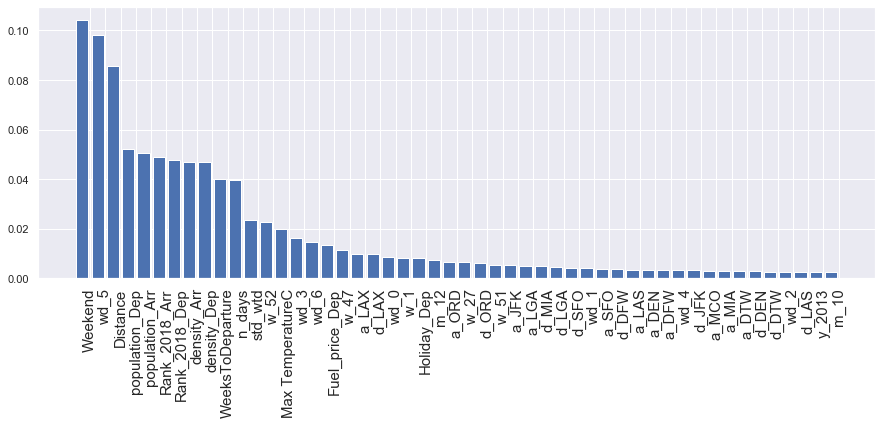

In [56]:
X_columns=X_train.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(GB.feature_importances_)[::-1][:50]

importances = GB.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);
#plots showing how important each column is in the prediction

In [57]:
y_pred_train = GB.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.1320676259321254


In [58]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)


In [59]:
X_test

,WeeksToDeparture,std_wtd,Max TemperatureC,Rank_2018_Dep,population_Dep,density_Dep,ranking_Dep,Fuel_price_Dep,Holiday_Dep,Rank_2018_Arr,population_Arr,density_Arr,ranking_Arr,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,Distance,Weekend,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.000000,9.860938,19,9,2073045.0,1747.0,1,2918,0,3,8675982.0,4612.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2450.531839,0.0,15481,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10.600000,9.954634,8,7,3603761.0,7286.0,1,2977,0,5,2787266.0,1774.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1536.901253,0.0,15694,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,11.950000,9.207977,10,21,19354922.0,11083.0,1,2938,0,19,3522206.0,1873.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,786.157237,0.0,15645,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,11.476190,9.352107,19,5,2787266.0,1774.0,1,304,0,9,2073045.0,1747.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,990.537032,0.0,15342,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,13.444444,10.363892,16,2,12815475.0,3295.0,1,3052,0,1,5228750.0,1384.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3120.683258,0.0,15663,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,11.045455,7.791798,20,5,2787266.0,1774.0,1,2936,1,13,4081849.0,1212.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,941.475326,0.0,15302,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2222,11.000000,7.937254,35,1,5228750.0,1384.0,1,3279,0,5,2787266.0,1774.0,1,1,0,0,0,0,0,0,0,0

In [60]:
y_pred = GB.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.3673803372534704


#### Grid Search GB


### XGBoost

In [34]:
import xgboost as xgb

In [35]:
xgb_model = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.05, max_depth= 7, min_child_weight=4, n_estimators= 500, nthread= 4, objective='reg:linear', silent=1, subsample= 0.7)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=None, n_estimators=5000,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

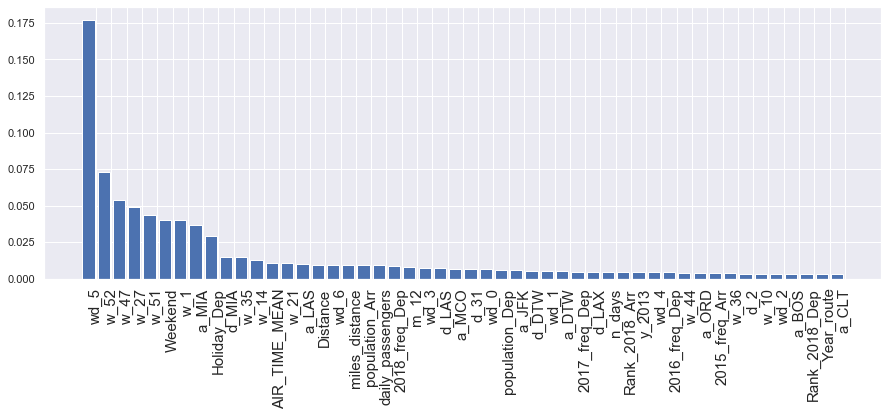

In [36]:
X_columns=X_train.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(xgb_model.feature_importances_)[::-1][:50]

importances = xgb_model.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);
#plots showing how important each column is in the prediction

In [37]:
y_pred_train = xgb_model.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.0019067960499282064


In [38]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
#X_test = enc.transform(X_test)


In [39]:
y_pred = xgb_model.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.3396399950905846


In [41]:

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7, 10, 15, 20, 30],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 21 candidates, totalling 42 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  42 out of  42 | elapsed: 11.5min finished


0.8631457650455636
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


### Random Forest

In [84]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [174]:
RF = RandomForestRegressor(
            n_estimators=600, max_depth=110, max_features='sqrt',
             min_samples_split=10, min_samples_leaf=1, bootstrap=True)
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=110,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [175]:
y_pred_train = RF.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.5299638112861172


In [176]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = RF.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

ValueError: could not convert string to float: '2012-05-21'

### Lasso

In [ ]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [92]:
LR = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
LR.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=1, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [93]:
y_pred_train = LR.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.5913207660217837


In [94]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = LR.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.6299112404459802


### ElasticNet

In [ ]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [97]:
EN = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
EN.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True,
                            l1_ratio=0.9, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=3,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [98]:
y_pred_train = EN.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.5909815480494767


In [99]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = EN.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.6297524587201996


### Ada Boost

In [32]:
from sklearn.ensemble import AdaBoostRegressor
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [33]:
AR=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
        n_estimators=100, random_state=0)
AR.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=0)

In [34]:
y_pred_train = AR.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.7000046022054104


In [35]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = AR.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.7268548027080755


### Neural Networks

In [36]:
from sklearn.neural_network import MLPRegressor

In [38]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [40]:
MLP=MLPRegressor()
MLP.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [41]:
y_pred_train = MLP.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  366.32065164002256


In [42]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = MLP.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  368.84342054758105


### Average

In [42]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [45]:
GB = GradientBoostingRegressor(n_estimators=500,
            learning_rate=0.05, max_depth=3, max_features='sqrt',
            min_samples_leaf=15, min_samples_split=10, loss='huber')

xgb_model = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.05, max_depth= 7, min_child_weight=4, n_estimators= 500, nthread= 4, objective='reg:linear', silent=1, subsample= 0.7)
averaged_models = AveragingModels(models = (GB, xgb_model))


In [46]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [47]:
averaged_models.fit(X_train, y_train)

AveragingModels(models=(GradientBoostingRegressor(alpha=0.9,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.05,
                                                  loss='huber', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=15,
                                                  min_samples_split=10,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=500,
                                                  n_iter_no_change=None,
                                               

In [48]:
y_pred_train = averaged_models.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.2790973560460278


In [49]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = averaged_models.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.396312228790203


### Custom Thomas Stack

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

### Stack

In [88]:

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        self.meta_model_ = clone(self.meta_model)
        #kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        '''
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                print('train index: ',train_index)
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
        '''
        
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
        
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in models]).mean(axis=1)
            for models in self.models_ ])
        
        self.meta_model_.fit(meta_features, y)
        final_prediction=self.meta_model_.predict(meta_features)
        return final_prediction

In [89]:
GB = GradientBoostingRegressor(n_estimators=12000,
            learning_rate=0.05, max_depth=3, max_features='sqrt',
            min_samples_leaf=15, min_samples_split=10, loss='huber')

RF = RandomForestRegressor(
            n_estimators=600, max_depth=110, max_features='sqrt',
             min_samples_split=10, min_samples_leaf=1, bootstrap=True)

LR = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

EN = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

stacked_averaged_models =StackingAveragedModels(base_models = (GB, RF, EN),
                                                 meta_model = LR)


In [90]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)

In [91]:
stacked_averaged_models.fit(X_train, y_train)

StackingAveragedModels(base_models=None,
                       meta_model=Pipeline(memory=None,
                                           steps=[('robustscaler',
                                                   RobustScaler(copy=True,
                                                                quantile_range=(25.0,
                                                                                75.0),
                                                                with_centering=True,
                                                                with_scaling=True)),
                                                  ('lasso',
                                                   Lasso(alpha=0.0005,
                                                         copy_X=True,
                                                         fit_intercept=True,
                                                         max_iter=1000,
                                                         normalize=F

In [92]:
y_pred_train = stacked_averaged_models.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

AttributeError: 'numpy.ndarray' object has no attribute 'predict'

In [ ]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
y_pred = stacked_averaged_models.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

## New external (each line is a flight)

In [96]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159
...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967
8898,2012-09-25,DFW,ORD,12.772727,10.641034
8899,2012-01-19,SFO,LAS,11.047619,7.908705
8900,2013-02-03,ORD,PHL,6.076923,4.030334


In [82]:
import os
from math import *


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def transform(X_df):
    X_encoded = X_df.copy()
    #a mettre dans le fit
    X_encoded['passengers'] = y_train

    
    #Read data

    ext_data1 = pd.read_csv('data/final_external2.csv')
    ext_data2 = pd.read_csv('data/final_external2.csv')

    ext_data1 = ext_data1.drop('Unnamed: 0', axis=1)
    ext_data2 = ext_data2.drop('Unnamed: 0', axis=1)
    
    ext_data2 = ext_data2.rename(columns={'IATA_Dep':'IATA_Arr', 'IATA_Arr':'IATA_Dep'})
    ext_data = pd.concat([ext_data1, ext_data2])

    X_encoded = X_encoded.merge(ext_data, left_on=['Departure', 'Arrival'], right_on=['IATA_Dep', 'IATA_Arr'])
    X_encoded = X_encoded.drop(['IATA_Dep', 'IATA_Arr', 'Date'],axis=1)
    
    
    #Distance calculation
    X_encoded['Distance']=X_encoded.apply(lambda x:
    haversine(x['lng_Dep'],x['lat_Dep'],x['lng_Arr'],x['lat_Arr']),axis=1)
    
    
    #Dummy Date
    X_encoded['Weekend'] = ((pd.DatetimeIndex(X_encoded['DateOfDeparture']).dayofweek) // 5 == 1).astype(float)
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

    #We one hot encode all those
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))
    X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
    X_encoded = X_encoded.drop([ 'State_Arr', 
                                'State_Dep','Min TemperatureC_Dep',
                                'Dew PointC_Dep','MeanDew PointC_Dep','Min DewpointC_Dep','Max Humidity_Dep',
                                'Mean Humidity_Dep','Min Humidity_Dep','Max Sea Level PressurehPa_Dep',
                                'Mean Sea Level PressurehPa_Dep','Min Sea Level PressurehPa_Dep','Max VisibilityKm_Dep',
                                'Mean VisibilityKm_Dep','Min VisibilitykM_Dep','Max Wind SpeedKm/h_Dep','Mean Wind SpeedKm/h_Dep',
                                'Max Gust SpeedKm/h_Dep','WindDirDegrees_Dep',
                               'Min TemperatureC_Arr',
                                'Dew PointC_Arr','MeanDew PointC_Arr','Min DewpointC_Arr','Max Humidity_Arr',
                                'Mean Humidity_Arr','Min Humidity_Arr','Max Sea Level PressurehPa_Arr',
                                'Mean Sea Level PressurehPa_Arr','Min Sea Level PressurehPa_Arr','Max VisibilityKm_Arr',
                                'Mean VisibilityKm_Arr','Min VisibilitykM_Arr','Max Wind SpeedKm/h_Arr','Mean Wind SpeedKm/h_Arr',
                                'Max Gust SpeedKm/h_Arr','WindDirDegrees_Arr'], axis=1)


    


    return X_encoded



In [83]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train = transform(X_train)
X_train

/anaconda3/envs/air_passengers/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [84]:
X_train

,Departure,Arrival,WeeksToDeparture,std_wtd,2015_Arr,2015_Dep,2016_Arr,2016_Dep,2017_Arr,2017_Dep,2018_Arr,2018_Dep,Fuel_price,Holiday,LOAD_FACTOR_Arr,LOAD_FACTOR_Dep,Max TemperatureC_Arr,Max TemperatureC_Dep,Mean TemperatureC_Arr,Mean TemperatureC_Dep,Rank_2018_Arr,Rank_2018_Dep,Unnamed: 0.1,Year,average_fare,city_Arr,city_Dep,daily_passengers,density_Arr,density_Dep,lat_Arr,lat_Dep,lng_Arr,lng_Dep,miles_distance,population_Arr,population_Dep,quarter,ranking_Arr,ranking_Dep,Distance,Weekend,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,ORD,DFW,12.875000,9.812647,31589832,36305668,31283579,37589899,31816933,38593028,32800721,39874879,3088,0,81.82,81.82,38,34,33,28,4,3,183,2011,216.03,Dallas,Chicago,3146,1524.0,4612.0,32.7936,41.8373,-96.7662,-87.6862,802,5733259.0,8675982.0,3,1,1,1285.250403,0.0,2012,6,19,1,25,15510,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ORD,DFW,11.130435,7.027895,31589832,36305668,31283579,37589899,31816933,38593028,32800721,39874879,3088,0,81.82,81.82,38,34,33,28,4,3,183,2011,216.03,Dallas,Chicago,3146,1524.0,4612.0,32.7936,41.8373,-96.7662,-87.6862,802,5733259.0,8675982.0,3,1,1,1285.250403,0.0,2012,7,19,3,29,15540,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ORD,DFW,12.652174,9.527991,31589832,36305668,31283579,37589899,31816933,38593028,32800721,39874879,3088,0,81.82,81.82,38,34,33,28,4,3,183,2011,216.03,Dallas,Chicago,3146,1524.0,4612.0,32.7936,41.8373,-96.7662,-87.6862,802,5733259.0,8675982.0,3,1,1,1285.250403,0.0,2011,12,9,4,49,15317,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,ORD,DFW,11.263158,9.170254,31589832,36305668,31283579,37589899,31816933,38593028,32800721,39874879,3088,0,81.82,81.82,38,34,33,28,4,3,183,2011,216.03,Dallas,Chicago,3146,1524.0,4612.0,32.7936,41.8373,-96.7662,-87.6862,802,5733259.0,8675982.0,3,1,1,1285.250403,0.0,2012,3,26,0,13,15425,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ORD,DFW,10.136364,7.716991,31589832,36305668,31283579,37589899,31816933,38593028,32800721,39874879,3088,0,81.82,81.82,38,34,33,28,4,3,183,2011,216.03,Dallas,Chicago,3146,1524.0,4612.0,32.7936,41.8373,-96.7662,-87.6862,802,5733259.0,8675982.0,3,1,1,1285.250403,0.0,2012,10,17,2,42,15630,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [26]:
%time
GB = GradientBoostingRegressor()
GB.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

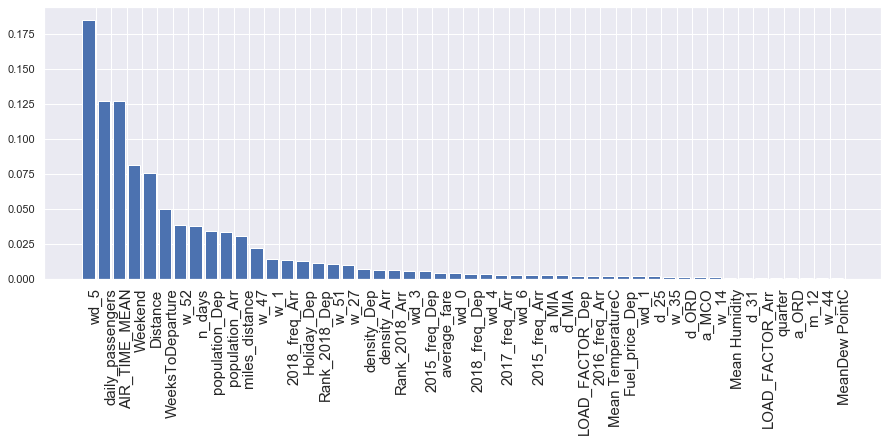

In [27]:
X_columns=X_train.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(GB.feature_importances_)[::-1][:50]

importances = GB.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);
#plots showing how important each column is in the prediction

In [28]:
y_pred_train = GB.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.443135860554676


In [29]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)
X_test

,WeeksToDeparture,Mean TemperatureC,MeanDew PointC,Mean Humidity,Mean Sea Level PressurehPa,Mean VisibilityKm,Mean Wind SpeedKm/h,CloudCover,Rank_2018_Dep,population_Dep,density_Dep,Fuel_price_Dep,Holiday_Dep,LOAD_FACTOR_Dep,2018_freq_Dep,2017_freq_Dep,2016_freq_Dep,2015_freq_Dep,Rank_2018_Arr,population_Arr,density_Arr,LOAD_FACTOR_Arr,2018_freq_Arr,2017_freq_Arr,2016_freq_Arr,2015_freq_Arr,Distance,Weekend,quarter,n_days,Year_route,Quarter_route,miles_distance,daily_passengers,average_fare,AIR_TIME_MEAN,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.000000,16,7,56,1020,16,20,5,9,2073045.0,1747.0,2.918,0,84.45,23655285,23364393,22833267,21824231,3,8675982.0,4612.0,84.45,39874879,38593028,37589899,36305668,2450.531839,0.0,2,15481,2012.0,2.0,1521.0,3512.0,197.42,9918.59,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10.600000,-2,-17,35,1024,16,21,1,7,3603761.0,7286.0,2.977,0,81.54,27794154,26900048,25707101,24190549,5,2787266.0,1774.0,81.54,31363573,29809097,28267394,26280043,1536.901253,0.0,4,15694,2012.0,4.0,967.0,3238.0,198.27,4913.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,11.950000,7,0,64,1006,16,20,7,21,19354922.0,11083.0,2.938,0,82.78,15059648,14614802,14706123,14762593,19,3522206.0,1873.0,82.78,17437716,17036092,16826287,16255520,786.157237,0.0,4,15645,2012.0,4.0,540.0,2669.0,224.18,3771.46,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,11.476190,13,-7,26,1026,16,10,3,5,2787266.0,1774.0,3.040,0,78.02,31363573,29809097,28267394,26280043,9,2073045.0,1747.0,78.02,23655285,23364393,22833267,21824231,990.537032,0.0,1,15342,2012.0,1.0,628.0,2364.0,137.04,4600.33,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,13.444444,12,8,73,1025,13,11,6,2,12815475.0,3295.0,3.052,0,82.78,42626783,41232432,39636042,36351226,1,5228750.0,1384.0,82.78,51866464,50251964,50501858,49340732,3120.683258,0.0,4,15663,2012.0,4.0,1947.0,2664.0,267.67,12191.76,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [31]:
y_pred = GB.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.47891459982524265


In [16]:
large = pd.read_csv('data/external_data_large.csv')
large

,Unnamed: 0,Date,AirPort,Mean TemperatureC,MeanDew PointC,Mean Humidity,Mean Sea Level PressurehPa,Mean VisibilityKm,Mean Wind SpeedKm/h,Precipitationmm,CloudCover,Rank_2018,State,2018_freq,2017_freq,2016_freq,2015_freq,city,lat,lng,population,density,Fuel_price,Holiday,Month,Year,Quarter,LOAD_FACTOR,Year_route,Quarter_route,miles_distance,daily_passengers,average_fare,ROUTE,AIR_TIME_MEAN
0,0,2011-09-01,ATL,29,18,56,1019,16,6,0.00,3,1,GA,51866464,50251964,50501858,49340732,Atlanta,33.7627,-84.4225,5228750.0,1384.0,3.088,0,9,2011,3,81.82,2011.0,3.0,952.0,2335.0,208.31,ATLBOS,6002.21
1,1,2011-09-01,ORD,28,22,70,1013,15,9,0.00,1,3,IL,39874879,38593028,37589899,36305668,Chicago,41.8373,-87.6862,8675982.0,4612.0,3.088,0,9,2011,3,81.82,2011.0,4.0,952.0,2117.0,227.89,ATLBOS,6002.21
2,2,2011-09-01,LAX,18,14,76,1011,11,13,0.00,5,2,CA,42626783,41232432,39636042,36351226,Los Angeles,34.1139,-118.4068,12815475.0,3295.0,3.088,0,9,2011,3,81.82,2012.0,1.0,952.0,1704.0,235.04,ATLBOS,6002.21
3,3,2011-09-01,DFW,33,14,35,1013,16,14,0.00,1,4,TX,32800721,31816933,31283579,31589832,Dallas,32.7936,-96.7662,5733259.0,1524.0,3.088,0,9,2011,3,81.82,2012.0,2.0,952.0,2335.0,226.73,ATLBOS,6002.21
4,4,2011-09-01,DEN,28,3,22,1007,16,15,0.00,5,5,CO,31363573,29809097,28267394,26280043,Denver,39.7621,-104.8759,2787266.0,1774.0,3.088,0,9,2011,3,81.82,2012.0,3.0,952.0,2437.0,196.87,ATLBOS,6002.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11035,11035,2013-03-05,MSP,-3,-5,85,1019,6,15,10.41,8,17,MN,18363493,18409704,18123844,17634252,Minneapolis,44.9635,-93.2678,2926757.0,3019.0,3.021,0,3,2013,1,84.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11036,11036,2013-03-05,DTW,-2,-6,69,1016,16,16,0.00,5,19,MI,17437716,17036092,16826287,16255520,Detroit,42.3834,-83.1024,3522206.0,1873.0,3.021,0,3,2013,1,84.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11037,11037,2013-03-05,PHL,4,-6,53,1016,16,11,0.00,3,20,PA,15285948,14271243,14564419,15101318,Philadelphia,40.0077,-75.1339,5637884.0,4547.0,3.021,0,3,2013,1,84.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11038,11038,2013-03-05,BOS,3,-3,68,1014,16,17,T,7,16,MA,20010262,18759742,17749202,16290362,Boston,42.3188,-71.0846,4637537.0,5472.0,3.021,0,3,2013,1,84.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:

def transform(X_df):
    def haversine(lon1, lat1, lon2, lat2):
        # Function to compute the great circle distance between 2 points on Earth

        # a. Convert decimal degrees (latitude & longitude) to radians 
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        # b. Haversine formula
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Earth radius in kilometers (in miles: 3956)
        return c * r

    # 1) Reading data:

    X_encoded = X_df.copy()
    __file__ = 'submissions/starting_kit/'
    path = os.path.dirname(__file__)
    external_data_large = pd.read_csv('data/external_data_large.csv')

    # 2) Starting with weather data transformation and merging with X_encoded:

    X_weather = external_data_large[['Date', 'AirPort', 'Mean TemperatureC', 'MeanDew PointC', 
                                     'Mean Humidity', 'Mean Sea Level PressurehPa', 'Mean VisibilityKm',
                                     'Mean Wind SpeedKm/h', 'CloudCover']]
    X_weather = X_weather.rename(columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})

    X_encoded = pd.merge(X_encoded, X_weather, how = 'left',
        left_on = ['DateOfDeparture', 'Arrival'],
        right_on = ['DateOfDeparture', 'Arrival'],
        sort = False)

    # 3) Airport external data transformation and merging:

    airport_data = external_data_large[['Date', 'AirPort','Rank_2018','State','city','lat',
                                        'lng','population','density','Fuel_price','Holiday',
                                        'LOAD_FACTOR','2018_freq','2017_freq', '2016_freq',
                                        '2015_freq']]

    ## We need to distinguish data related to departure and arrival airports
    Dep_data = airport_data.add_suffix('_Dep')
    Arr_data = airport_data.add_suffix('_Arr')

    ## We then merge departure and arrival information with X_encoded
    X_encoded = pd.merge(X_encoded, Dep_data, how = 'left', 
        left_on = ['DateOfDeparture', 'Departure'],
        right_on = ['Date_Dep', 'AirPort_Dep'],
        sort = False)

    X_encoded = pd.merge(X_encoded, Arr_data, how = 'left', 
        left_on = ['DateOfDeparture', 'Arrival'],
        right_on = ['Date_Arr', 'AirPort_Arr'],
        sort = False)

    ## Distance calculation
    X_encoded['Distance'] = X_encoded.apply(lambda x: 
        haversine(x['lng_Dep'], x['lat_Dep'], x['lng_Arr'], x['lat_Arr']), axis = 1)

    # 4) Route external data transformation and merging

    ## Add route information in X_encoded
    X_encoded['ROUTE'] = X_encoded[['Departure', 'Arrival']].apply(''.join, axis=1)

    ## Dummy Dates
    X_encoded['Weekend'] = ((pd.DatetimeIndex(X_encoded['DateOfDeparture']).dayofweek) // 
        5 == 1).astype(float)
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded['quarter'] = X_encoded['DateOfDeparture'].dt.quarter
    X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date:
        (date - pd.to_datetime("1970-01-01")).days)

    ## Select flight route data in external dataset
    route_data = external_data_large[['Year_route', 'Quarter_route', 'miles_distance', 
                                      'daily_passengers', 'average_fare', 'ROUTE', 'AIR_TIME_MEAN']]

    ## Merge the flight route data with X_encoded
    X_encoded = pd.merge(X_encoded, route_data, how = 'left', 
        left_on = ['year','quarter','ROUTE'],
        right_on = ['Year_route','Quarter_route','ROUTE'],
        sort = False)

    # 5) Dummy variables and encoding:

    ## Dummy Departure / Arrival airports
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix = 'd'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix = 'a'))

    ## One-hot encoding of categorical features
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))
    X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
    X_encoded = X_encoded.drop('Departure', axis=1)
    X_encoded = X_encoded.drop('Arrival', axis=1)

    X_encoded['Rank_2018_Arr'] = X_encoded['Rank_2018_Arr'].astype(int)
    X_encoded['Rank_2018_Dep'] = X_encoded['Rank_2018_Dep'].astype(int)

    # 5) Final feature selection (dropping unuseful features):

    X_encoded = X_encoded.drop(['Date_Dep','Date_Arr','city_Dep','city_Arr','AirPort_Dep',
                              'State_Dep', 'AirPort_Arr', 'State_Arr','Fuel_price_Arr',
                              'Holiday_Arr','year','month','week','day','weekday','lat_Dep',
                              'lng_Dep','lat_Arr','lng_Arr','ROUTE','std_wtd'], axis=1)
    return X_encoded

In [33]:
X_train = X_df.copy()
y_train = y_array.copy()
X_train =transform(X_train)
X_train

,WeeksToDeparture,Mean TemperatureC,MeanDew PointC,Mean Humidity,Mean Sea Level PressurehPa,Mean VisibilityKm,Mean Wind SpeedKm/h,CloudCover,Rank_2018_Dep,population_Dep,density_Dep,Fuel_price_Dep,Holiday_Dep,LOAD_FACTOR_Dep,2018_freq_Dep,2017_freq_Dep,2016_freq_Dep,2015_freq_Dep,Rank_2018_Arr,population_Arr,density_Arr,LOAD_FACTOR_Arr,2018_freq_Arr,2017_freq_Arr,2016_freq_Arr,2015_freq_Arr,Distance,Weekend,quarter,n_days,Year_route,Quarter_route,miles_distance,daily_passengers,average_fare,AIR_TIME_MEAN,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.875000,29,21,63,1010,16,29,5,3,8675982.0,4612.0,2.719,0,86.62,39874879,38593028,37589899,36305668,4,5733259.0,1524.0,86.62,32800721,31816933,31283579,31589832,1285.250403,0.0,2,15510,2012.0,2.0,802.0,3220.0,228.67,7560.62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,25,-6,14,1008,16,15,3,9,2073045.0,1747.0,3.247,0,80.64,23655285,23364393,22833267,21824231,5,2787266.0,1774.0,80.64,31363573,29809097,28267394,26280043,990.537032,0.0,3,15593,2012.0,3.0,628.0,2286.0,123.86,4407.42,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,19,16,77,1016,13,8,5,5,2787266.0,1774.0,3.158,0,84.23,31363573,29809097,28267394,26280043,2,12815475.0,3295.0,84.23,42626783,41232432,39636042,36351226,1354.641049,0.0,4,15618,2012.0,4.0,862.0,4379.0,172.05,5667.64,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,19,10,58,1026,16,6,1,1,5228750.0,1384.0,2.881,0,83.63,51866464,50251964,50501858,49340732,3,8675982.0,4612.0,83.63,39874879,38593028,37589899,36305668,942.326564,1.0,4,15256,2011.0,4.0,606.0,2746.0,193.12,3693.83,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,12,8,79,1025,12,8,7,5,2787266.0,1774.0,3.237,0,78.90,31363573,29809097,28267394,26280043,7,3603761.0,7286.0,78.90,27794154,26900048,25707101,24190549,1536.901253,0.0,1,15391,2012.0,1.0,967.0,2681.0,182.97,5300.04,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..